# Experiments Notebbok
* In this notebook various functions are created and tested for to see how well the will work. You are more than welcome to go through it if some part of the program isn't easy to understand.

## Genetic Algorithm
* Now we work on encode / decode block for Genetic Algorithms. Since we have a configuration of string as 
  $$ x_i \in \begin{cases}\{0,1\} & 1 \le i\le 21\\\{0,1,2\} & 22 \le i \le 26\end{cases} $$
  and GA works on bitstring, I decided to represent it as follows:
  $$0 \rightarrow 01$$
  $$1 \rightarrow 10$$
  $$2 \rightarrow 11$$
* Hence when encoding, the data should be encoded in a bitstring of length $31$.
  * $0-21$ will be copied as it is.
  * $22-26$ will be encodind in 2 bits.
  * As for the $00$, I decided to set it as $1$ but also return a flag stating whether or not the Decoding was "successful". Will experiment with it, either will force Mutation or just use the output string.

In [95]:
a = [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2]
def EncodeDNA(configurationString):
    if len(configurationString) != 26:
        raise "Expected size 26"
    dna = configurationString[:21]
    for i in range(len(configurationString) - 21):
        if configurationString[i + 21] == 0:
            dna.append(0)
            dna.append(1)
        elif configurationString[i + 21] == 1:
            dna.append(1)
            dna.append(0)
        elif configurationString[i + 21] == 2:
            dna.append(1)
            dna.append(1)
        else:
            raise "Unexected value in eocndoing"
    return dna

x = EncodeDNA(a)
print(x)

[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]


# Addressing the filter selection.
* Since we only have three distinct filters, which we pick $5$ times, the last $10$ bits has a chance of being invalid, since we are not using $00$ for anything. This can be solved by:
  * Forcing Mutation of the last $10$ bits till they are valid.
  * Decode $00$ as one of the $\{0, 1, 2\}$ randomly.
* The `EncodeDNA` function already returns the first bit that is invalid while encoding those bits as $1$, I can modify that function to either randomize those bits or setup a loop with `ForceMutate` function below. However, I chose to randomise the output when bitstring is $00$. This should help with the diversity of the population.
* Hence we have decoding of: $$00 \rightarrow random(0, 2)$$ $$01 \rightarrow 0$$ $$10 \rightarrow 1$$ $$11 \rightarrow 2$$

In [147]:
beta = [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
def DecodingDNA(dna):
    if len(dna) != 31:
        raise "Unexpected size, expected bitstring of length 31"
    configurationString = dna[:21]
    fault = -1
    for i in range(len(dna) - 21):
        index = i + 21
        if index % 2 == 1:
            if dna[index] == 0 and dna[index + 1] == 1:
                configurationString.append(0)
            elif dna[index] == 1 and dna[index + 1] == 0:
                configurationString.append(1)
            elif dna[index] == 1 and dna[index + 1] == 1:
                configurationString.append(2)
            else:
                configurationString.append(np.random.randint(0, 3))
                fault = (index)
    return (fault, configurationString)

y = DecodingDNA(beta)
print(y[0], y[1])

y = DecodingDNA(x)
print(y[0], y[1])


29 [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 2]
-1 [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2]


In [97]:
a == y[1]

True

# Mate Selection
 * Now we write a code on the mate selection process. Here we hace a tournament selection Mating selection process, in which the since the invalid neural architecture returns accuracy as $0$, they will automatically eliminated. 
 * Then we plot the graph of the data so mate selection process against expected result and validate their results.
 * Since we are selecting according to fitness, we will need: $$N \times \frac{f(x_i)}{\sum_{i = 1}^N f(x_i)}$$ number of repetations of $parent_i$.

In [177]:
# Using the tournament selection
import numpy as np

np.random.seed(420)

def MatingSeletion(parent, fitness, selectionSize) : 
    if len(parent) != len(fitness):
        raise "Parent length and parent function length mismatch."
    selectionTable = [0] 
    new_population = [] 
    total = 0
    for i in range(len(fitness)):
        selectionTable.append(selectionTable[i] + fitness[i])
        total += fitness[i]
    if total == 0:
        choices = np.random.randint(0, len(fitness), size=len(fitness))
        for choice in choices:
            new_population.append(parent[choice])
        return new_population
    luckyGuys = np.random.random(size=selectionSize)
    for luckyGuy in luckyGuys:
        luckyGuy *= total
        for j in range(len(selectionTable) - 1):
            if luckyGuy >= selectionTable[j] and luckyGuy < selectionTable[j+1]:
                new_population.append(parent[j])
                break
    return new_population
parent = "a b c d e f g h i j".split(" ")
fitness = [0.10, 0.4, 0.5, 0.8, 0.6, 0.4, 0.2, 0.1, 0.9, 0.7]
selectionSize = 10000
newPop = MatingSeletion(parent=parent, fitness=fitness, selectionSize=selectionSize)

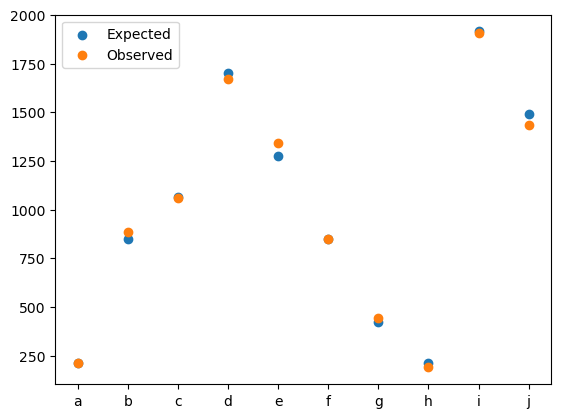

In [178]:
import matplotlib.pyplot as plt

newPopDict = {}
for individual in newPop:
    if not newPopDict.keys().__contains__(individual):
        newPopDict[individual] = 1
    else:
        newPopDict[individual] += 1

newPopDict

total = 0
for fit in fitness:
    total += fit

expectedPopDict = {}
for i in range(len(parent)):
    expectedPopDict[parent[i]] = fitness[i] * selectionSize / total

expectedPopDict

plt.scatter(expectedPopDict.keys(), expectedPopDict.values(), label="Expected")
plt.scatter(newPopDict.keys(), newPopDict.values(), label="Observed")
plt.legend()
plt.show()

# Mutation Algorithm
* For this implementation, we have a `Decision(p_m)` stub that decides when to mutate, and `MutateDNA(vector, p_m)` mutate the DNA vector using mutation vector $p_m$.
* The `Decision(p_m)` vector will also come in handy during crossover.

In [100]:
p_m = 0.1

def Decision(p_m):
    if p_m > 1:
        raise "Probability greter than 1"
    x = np.random.random()
    if x < p_m:
        return True
    return False

mutateDict = {}
for i in range(10000):
    key = Decision(p_m)
    if mutateDict.keys().__contains__(key):
        mutateDict[key] += 1
    else:
        mutateDict[key] = 1

expectedDict = {}
expectedDict[True] = 10000 * p_m
expectedDict[False] = 10000 * (1 - p_m)

print(f"Expected distribution: {expectedDict} \n Actual value {mutateDict}")


Expected distribution: {True: 1000.0, False: 9000.0} 
 Actual value {True: 1016, False: 8984}


In [101]:
def MutateDNA(vector, p_m):
    if len(vector) != 31:
        raise "MutateDNA: Expected vector of length 31."
    for i in range(len(vector)):
        if Decision(p_m=p_m):
            if vector[i] == 0: vector[i] = 1
            else: vector[i] = 0
    return vector

vec = np.zeros(31)
MutateDNA(vec, p_m=1/31)    

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Crossover
* For crossover I decided to make a flexible algorithm that does $n$ point Crossover upto $10$ points, and if `xpointCount` is out of that range, it resorts to uniform crossover.

In [102]:
def crossOverPoint(length, xpoints):
    if length - 2 <= xpoints:
        raise "crossOverPoint: Too many crossover points."
    x = list(range(1, length - 1))
    xpts = []
    for _ in range(xpoints):
        temp = x[np.random.randint(0, len(x) - 1)]
        xpts.append(temp)
        x.remove(temp)
    xpts.sort()
    return xpts


def Crossover(parent1, parent2, p_x, xpointCount):
    if len(parent1) != 31 and len(parent2) != 31:
        raise "Parent not of same species, expected size of 31 bor both."
    if xpointCount > 10 or xpointCount < 1:
        offspring = []
        for i in range(len(parent1)):
            if Decision(p_x):
                offspring.append(parent1[i])
            else:
                offspring.append(parent2[i])
        return offspring
    else:
        xpts = crossOverPoint(length=len(parent1), xpoints=xpointCount)
        p1 = True
        offspring = []
        for i in range(len(parent1)):
            if xpts.__contains__(i):
                p1 = not p1
            if p1:
                offspring.append(parent1[i])
            else:
                offspring.append(parent2[i])
        return offspring


print(Crossover(np.zeros(31), np.ones(31), 0.5, 10))

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Matrix Converter
* Now in order to feed the algorithm, we need a vector to matrix converter, since we need a matrix of type: $$\text{Adjacency matrix} = \begin{vmatrix}
0 & x_1 & x_2 & x_3 & x_4 & x_5 & x_6\\
0 & 0 & x_7 & x_8 & x_9 & x_{10} & x_{11}\\
0 & 0 & 0 & x_{12} & x_{13} & x_{14} & x_{15}\\
0 & 0 & 0 & 0 & x_{16} & x_{17} & x_{18}\\
0 & 0 & 0 & 0 & 0 & x_{19} & x_{20}\\
0 & 0 & 0 & 0 & 0 & 0 & x_{21}\\
0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{vmatrix}$$ we get the following code.

In [179]:
def GetMatrix(vector):
    if len(vector) != 26:
        raise "Expected vector of size 26"
    matrix = np.zeros((7,7))
    index = 0
    for i in range(7):
        for j in range(i+1, 7):
            matrix[i][j] = vector[index]
            index += 1
    return matrix

vector = list(range(1, 27))
vector
GetMatrix(vector=vector)

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [ 0.,  0.,  7.,  8.,  9., 10., 11.],
       [ 0.,  0.,  0., 12., 13., 14., 15.],
       [ 0.,  0.,  0.,  0., 16., 17., 18.],
       [ 0.,  0.,  0.,  0.,  0., 19., 20.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 21.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [104]:
GetMatrix(y[1])

array([[0., 1., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [170]:
INPUT = 'input'
OUTPUT = 'output'
CONV1X1 = 'conv1x1-bn-relu'
CONV3X3 = 'conv3x3-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'

operations = [CONV1X1,CONV3X3,MAXPOOL3X3]

print(y[1])

def GetFilters(vector):
    if len(vector) != 26:
        raise "GetFilters: Expected vector length 26"
    output = [INPUT]
    vector = vector[-5:]
    for x in vector:
        output.append(operations[x])
    output.append(OUTPUT)
    return output


GetFilters(y[1])

[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2]


['input',
 'conv3x3-bn-relu',
 'conv3x3-bn-relu',
 'conv1x1-bn-relu',
 'conv3x3-bn-relu',
 'maxpool3x3',
 'output']

# First Generation
* We are using 5 different Initialisation Method for the first generation, which I decided to have $21$ individuals for each genration.
* These $1^{st}$ genertions are of type:
  * Random Initialisation
  * $0^*10^*$ Initialisation
  * $1^*01^*$ Initialisation
  * $0^*1^*$ Initialisation
  * $1^*0^*$ Initialisation
## Random Initialisation
$$\prod_{i= 0}^{20} random(0,1) \prod_{i = 1}^5 random(0,1,2)$$
## $0^*10^*$ Initialisation
$$\prod_{i = 0}^{20} 0^i10^{20-i-1}\prod_{i = 1}^5 random(0,1,2)$$
## $1^*01^*$ Initialisation
$$\prod_{i = 0}^{20} 1^i01^{20-i-1}\prod_{i = 1}^5 random(0,1,2)$$
## $0^*1^*$ Initialisation
$$\prod_{i = 0}^{20} 0^i1^{20-i}\prod_{i = 1}^5 random(0,1,2)$$
## $1^*0^*$ Initialisation
$$\prod_{i = 0}^{20} 1^i0^{20-i}\prod_{i = 1}^5 random(0,1,2)$$

In [158]:
def InitialiseParents(type):
    data = []
    if type > 5 or type <= 1:
        for _ in range(21):
            temp = []
            for _ in range(21):
                temp.append(np.random.randint(0, 2))
            for _ in range(5):
                temp.append(np.random.randint(0, 3))
            data.append(temp)
        return data
    if type == 2:
        for i in range(21):
            temp = []
            for _ in range(i):
                temp.append(0)
            temp.append(1)
            for _ in range(20 - i):
                temp.append(0)
            for _ in range(5):
                temp.append(np.random.randint(0, 3))
            data.append(temp)
        return data
    if type == 3:
        for i in range(21):
            temp = []
            for _ in range(i):
                temp.append(1)
            temp.append(0)
            for _ in range(20 - i):
                temp.append(1)
            for _ in range(5):
                temp.append(np.random.randint(0, 3))
            data.append(temp)
        return data
    if type == 4:
        for i in range(21):
            temp = []
            for _ in range(i):
                temp.append(0)
            for _ in range(21 - i):
                temp.append(1)
            for _ in range(5):
                temp.append(np.random.randint(0, 3))
            data.append(temp)
        return data
    if type == 5:
        for i in range(21):
            temp = []
            for _ in range(i):
                temp.append(1)
            for _ in range(21 - i):
                temp.append(0)
            for _ in range(5):
                temp.append(np.random.randint(0, 3))
            data.append(temp)
        return data

for parent in InitialiseParents(type=5):
    print(parent, len(parent))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1] 26
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1] 26
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1] 26
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1] 26
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 2] 26
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1] 26
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2] 26
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1] 26
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0] 26
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2] 26
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0] 26
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2] 26
[1, 1, 1, 1, 1, 

In [42]:
import numpy as np
def NewPopulationSelection(parent, offspring, type):
    if type != '+' and type != ',':
        raise "Expected type to be a sttring of value + or ,"
    if type == ",":
        return offspring
    else:
        return parent[3:] + offspring

y = NewPopulationSelection([1, 2, 3, 4], [5, 6, 7, 8], type= "+")
y
# val = np.zeros(42)
# val
# chuncklist = []
# chunckSize = 42//8
# for i in range(0, len(val), chunckSize):
#     chuncklist.append(val[i:i + chunckSize])
# chuncklist

[4, 5, 6, 7, 8]

In [4]:
a = ["a", "b", "c", "d"]
b = ["e", "f", "g", "h"]
d = ["i", "j", "k", "l"]
c = a + b
c = c[len(a):] + d
c

['e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

# Some results sorting.
